In [294]:
import pandas as pd
import numpy as np
import json
import re

In [295]:
df_restaurantes = pd.read_parquet(r'Datawarehouse\restaurantes.parquet')


In [296]:
# df_restaurantes = df_restaurantes[df_restaurantes['nombre'] =="Subway"]
df_restaurantes['origen'] = df_restaurantes['id_restaurante'].apply(len)
df_restaurantes['origen'] =  df_restaurantes['id_restaurante'].apply(lambda x: 1 if len(x) > 22 else 0)
df_restaurantes

,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
3,MTSW4McQd7CbVtyjqoe9mw,38.0,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",80,39.955505,-75.155564,"{'AcceptsInsurance': None, 'Accessibility': No...",4.000000,0
22,kfNv-JZpuN6TVNSO6hHdkw,14.0,Hibachi Express,"Steakhouses, Asian Fusion, Restaurants",20,39.904320,-86.053080,"{'AcceptsInsurance': None, 'Accessibility': No...",4.000000,0
29,sqSqqLy0sN8n2IZrAbzidQ,42.0,Domino's Pizza,"Pizza, Chicken Wings, Sandwiches, Restaurants",8,36.464747,-86.659187,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
35,aPNXGTDkf-4bjhyMBQxqpQ,38.0,Craft Hall,"Eatertainment, Arts & Entertainment, Brewpubs,...",65,39.962582,-75.135657,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
61,seKihQKpGGnCeLuELRQPSQ,14.0,Twin Peaks,"Sports Bars, American (New), American (Traditi...",257,39.906295,-86.047463,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
...,...,...,...,...,...,...,...,...,...,...
212005,0x87d246f0f9aa080f:0x5023e31e61a87f1c,4.0,Subway,"['Sandwich shop', 'Caterer', 'Fast food restau...",125,35.491484,-92.034937,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.199219,1
212009,0x87d28d5aa640a9c5:0x3c9cc5d3a99de80c,4.0,"Simple Simon's Pizza - Vilonia, AR","['Pizza Takeout', 'Italian restaurant', 'Pizza...",38,35.081871,-92.207739,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.500000,1
212010,0x88d9dd6e78851851:0x849dcf273582261c,9.0,Subpreme Grill,"['Sandwich shop', 'Fast food restaurant', 'Tak...",393,25.506121,-80.438215,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.300781,1
212011,0x89c6c4072624d2a9:0x4437b2d55e9a5811,38.0,Dunkin',"['Coffee shop', 'Bagel shop', 'Bakery', 'Break...",348,39.923594,-75.245269,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.000000,1


In [297]:
df_restaurantes['origen'].value_counts()

origen
1    97744
0    14170
Name: count, dtype: int64

In [298]:
# df_restaurantes = df_restaurantes[df_restaurantes.nombre.str.contains('Subway')]
# df_restaurantes = df_restaurantes[df_restaurantes.nombre.str.lower().str.contains('subway')]

In [299]:
# pd.DataFrame(pd.json_normalize(df_restaurantes.query("origen == 'Y'").atributos).isna().sum(),columns=['nulos']).sort_values(by="nulos")

In [300]:
# nulos > 95738
columnas = pd.DataFrame(pd.json_normalize(df_restaurantes.atributos).isna().sum(),columns=['nulos']).index.to_list()

In [301]:
columnas = ['Accessibility',
 'Amenities',
 'Atmosphere',
 'Crowd',
 'Dining options',
 'Health & safety',
 'Highlights',
 'Offerings',
 'Payments',
 'Popular for',
 'Service options']

### 1. DF atributos

In [302]:
df_atributos = pd.json_normalize(df_restaurantes.atributos).reset_index()[columnas].fillna(np.ndarray([]))

In [303]:
for col in columnas:
    df_atributos[col] = df_atributos[col].apply(str)
    df_atributos[col] = df_atributos[col].apply(lambda c: "[]" if c == '0.0' else c)
    # df_atributos[col] = df_atributos[col].apply(json.loads)
    

In [304]:
df_atributos

,Accessibility,Amenities,Atmosphere,Crowd,Dining options,Health & safety,Highlights,Offerings,Payments,Popular for,Service options
0,[],[],[],[],[],[],[],[],[],[],[]
1,[],[],[],[],[],[],[],[],[],[],[]
2,[],[],[],[],[],[],[],[],[],[],[]
3,[],[],[],[],[],[],[],[],[],[],[]
4,[],[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...
111909,['Wheelchair accessible entrance' 'Wheelchair ...,['Good for kids' 'High chairs'],['Casual'],['College students' 'Groups' 'Tourists'],['Lunch' 'Catering' 'Dessert'],['Mask required'],['Fast service'],"['Coffee' 'Comfort food' 'Healthy options' ""Ki...",['Debit cards'],['Lunch' 'Dinner' 'Solo dining'],['Curbside pickup' 'Takeout' 'Dine-in']
111910,['Wheelchair accessible entrance'],['Good for kids'],['Casual'],['Family-friendly'],[],[],[],['Comfort food' 'Quick bite'],[],['Lunch' 'Dinner'],['Takeout']
111911,['Wheelchair accessible entrance'],['Good for kids' 'High chairs'],['Casual' 'Cozy'],['College students' 'Groups' 'Tourists'],['Dessert'],[],[],['Comfort food' 'Healthy options' 'Quick bite'...,['NFC mobile payments'],['Lunch' 'Dinner' 'Solo dining'],['Takeout']
111912,['Wheelchair accessible entrance'],['Good for kids' 'Restroom' 'Wi-Fi'],['Casual'],['Family-friendly' 'Groups' 'Tourists'],['Breakfast' 'Lunch' 'Dessert'],[],['Fast service' 'Great coffee' 'Great tea sele...,['Coffee' 'Comfort food' 'Happy hour drinks' '...,['Debit cards' 'NFC mobile payments'],['Breakfast' 'Solo dining' 'Good for working o...,['Delivery' 'Drive-through' 'Takeout' 'Dine-in']


#### 1.2 Accessibility

In [305]:
df_atributos['Accessibility'] = df_atributos['Accessibility'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

df_atributos['Accessibility']

0                                                        []
1                                                        []
2                                                        []
3                                                        []
4                                                        []
                                ...                        
111909    [Wheelchair accessible entrance, Wheelchair ac...
111910                     [Wheelchair accessible entrance]
111911                     [Wheelchair accessible entrance]
111912                     [Wheelchair accessible entrance]
111913                     [Wheelchair accessible entrance]
Name: Accessibility, Length: 111914, dtype: object

In [306]:
columnas_accesibilidad =  df_atributos['Accessibility'].explode().unique()[1:].tolist()


In [307]:
df_accesibilidad = pd.DataFrame([[False] * len(columnas_accesibilidad)] * df_atributos.shape[0], columns=columnas_accesibilidad)

In [308]:
df_accesibilidad

,Wheelchair accessible entrance,Wheelchair accessible parking lot,Wheelchair accessible seating,Wheelchair accessible restroom,Wheelchair accessible elevator,Wheelchair-accessible car park,Wheelchair-accessible entrance,Wheelchair-accessible seating,Wheelchair-accessible toilet,Wheelchair-accessible lift,Assisted listening devices
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
111909,False,False,False,False,False,False,False,False,False,False,False
111910,False,False,False,False,False,False,False,False,False,False,False
111911,False,False,False,False,False,False,False,False,False,False,False
111912,False,False,False,False,False,False,False,False,False,False,False


In [309]:
for i, row in enumerate(df_atributos['Accessibility']):
    for j, val in enumerate(row):
        df_accesibilidad.loc[i, val] = True


In [310]:
df_restaurantes = df_restaurantes.reset_index().reset_index().drop(columns=['index']).rename({'level_0': 'index'}, axis=1, errors='ignore')
df_accesibilidad.reset_index().merge(df_restaurantes, on="index")


,index,Wheelchair accessible entrance,Wheelchair accessible parking lot,Wheelchair accessible seating,Wheelchair accessible restroom,Wheelchair accessible elevator,Wheelchair-accessible car park,Wheelchair-accessible entrance,Wheelchair-accessible seating,Wheelchair-accessible toilet,...,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
0,0,False,False,False,False,False,False,False,False,False,...,MTSW4McQd7CbVtyjqoe9mw,38.0,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",80,39.955505,-75.155564,"{'AcceptsInsurance': None, 'Accessibility': No...",4.000000,0
1,1,False,False,False,False,False,False,False,False,False,...,kfNv-JZpuN6TVNSO6hHdkw,14.0,Hibachi Express,"Steakhouses, Asian Fusion, Restaurants",20,39.904320,-86.053080,"{'AcceptsInsurance': None, 'Accessibility': No...",4.000000,0
2,2,False,False,False,False,False,False,False,False,False,...,sqSqqLy0sN8n2IZrAbzidQ,42.0,Domino's Pizza,"Pizza, Chicken Wings, Sandwiches, Restaurants",8,36.464747,-86.659187,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
3,3,False,False,False,False,False,False,False,False,False,...,aPNXGTDkf-4bjhyMBQxqpQ,38.0,Craft Hall,"Eatertainment, Arts & Entertainment, Brewpubs,...",65,39.962582,-75.135657,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
4,4,False,False,False,False,False,False,False,False,False,...,seKihQKpGGnCeLuELRQPSQ,14.0,Twin Peaks,"Sports Bars, American (New), American (Traditi...",257,39.906295,-86.047463,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111909,111909,True,True,False,True,False,False,False,False,False,...,0x87d246f0f9aa080f:0x5023e31e61a87f1c,4.0,Subway,"['Sandwich shop', 'Caterer', 'Fast food restau...",125,35.491484,-92.034937,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.199219,1
111910,111910,True,False,False,False,False,False,False,False,False,...,0x87d28d5aa640a9c5:0x3c9cc5d3a99de80c,4.0,"Simple Simon's Pizza - Vilonia, AR","['Pizza Takeout', 'Italian restaurant', 'Pizza...",38,35.081871,-92.207739,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.500000,1
111911,111911,True,False,False,False,False,False,False,False,False,...,0x88d9dd6e78851851:0x849dcf273582261c,9.0,Subpreme Grill,"['Sandwich shop', 'Fast food restaurant', 'Tak...",393,25.506121,-80.438215,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.300781,1
111912,111912,True,False,False,False,False,False,False,False,False,...,0x89c6c4072624d2a9:0x4437b2d55e9a5811,38.0,Dunkin',"['Coffee shop', 'Bagel shop', 'Bakery', 'Break...",348,39.923594,-75.245269,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.000000,1


In [311]:
df_accesibilidad.columns = ["access_" + c for c in df_accesibilidad.columns]
union = df_accesibilidad.reset_index().merge(df_restaurantes, on="index")

In [312]:
union

,index,access_Wheelchair accessible entrance,access_Wheelchair accessible parking lot,access_Wheelchair accessible seating,access_Wheelchair accessible restroom,access_Wheelchair accessible elevator,access_Wheelchair-accessible car park,access_Wheelchair-accessible entrance,access_Wheelchair-accessible seating,access_Wheelchair-accessible toilet,...,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
0,0,False,False,False,False,False,False,False,False,False,...,MTSW4McQd7CbVtyjqoe9mw,38.0,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",80,39.955505,-75.155564,"{'AcceptsInsurance': None, 'Accessibility': No...",4.000000,0
1,1,False,False,False,False,False,False,False,False,False,...,kfNv-JZpuN6TVNSO6hHdkw,14.0,Hibachi Express,"Steakhouses, Asian Fusion, Restaurants",20,39.904320,-86.053080,"{'AcceptsInsurance': None, 'Accessibility': No...",4.000000,0
2,2,False,False,False,False,False,False,False,False,False,...,sqSqqLy0sN8n2IZrAbzidQ,42.0,Domino's Pizza,"Pizza, Chicken Wings, Sandwiches, Restaurants",8,36.464747,-86.659187,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
3,3,False,False,False,False,False,False,False,False,False,...,aPNXGTDkf-4bjhyMBQxqpQ,38.0,Craft Hall,"Eatertainment, Arts & Entertainment, Brewpubs,...",65,39.962582,-75.135657,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
4,4,False,False,False,False,False,False,False,False,False,...,seKihQKpGGnCeLuELRQPSQ,14.0,Twin Peaks,"Sports Bars, American (New), American (Traditi...",257,39.906295,-86.047463,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111909,111909,True,True,False,True,False,False,False,False,False,...,0x87d246f0f9aa080f:0x5023e31e61a87f1c,4.0,Subway,"['Sandwich shop', 'Caterer', 'Fast food restau...",125,35.491484,-92.034937,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.199219,1
111910,111910,True,False,False,False,False,False,False,False,False,...,0x87d28d5aa640a9c5:0x3c9cc5d3a99de80c,4.0,"Simple Simon's Pizza - Vilonia, AR","['Pizza Takeout', 'Italian restaurant', 'Pizza...",38,35.081871,-92.207739,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.500000,1
111911,111911,True,False,False,False,False,False,False,False,False,...,0x88d9dd6e78851851:0x849dcf273582261c,9.0,Subpreme Grill,"['Sandwich shop', 'Fast food restaurant', 'Tak...",393,25.506121,-80.438215,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.300781,1
111912,111912,True,False,False,False,False,False,False,False,False,...,0x89c6c4072624d2a9:0x4437b2d55e9a5811,38.0,Dunkin',"['Coffee shop', 'Bagel shop', 'Bakery', 'Break...",348,39.923594,-75.245269,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.000000,1


In [313]:
df_atributos['Accessibility'].iloc[8536]

[]

#### 1.3 DF Amenities

In [314]:
df_atributos['Amenities'] = df_atributos['Amenities'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_amenities = df_atributos['Amenities'].explode().unique()[1:].tolist()
df_amenities = pd.DataFrame([[False] * len(columnas_amenities)] * df_atributos.shape[0], columns=columnas_amenities)

for i, row in enumerate(df_atributos['Amenities']):
    for j, val in enumerate(row):
        df_amenities.loc[i, val] = True

df_amenities.columns = ["amen_" + c for c in df_amenities.columns]
union = df_amenities.reset_index().merge(union, on="index")

#### 1.4 Atmosphere

In [315]:
df_atributos['Atmosphere'] = df_atributos['Atmosphere'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_atmosphere = df_atributos['Atmosphere'].explode().unique()[1:].tolist()

df_atmosphere = pd.DataFrame([[False] * len(columnas_atmosphere)] * df_atributos.shape[0], columns=columnas_atmosphere)

for i, row in enumerate(df_atributos['Atmosphere']):
    for j, val in enumerate(row):
        df_atmosphere.loc[i, val] = True

df_atmosphere.columns = ["atmos_" + c for c in df_atmosphere.columns]
union = df_atmosphere.reset_index().merge(union, on="index")

#### 1.5 Crowd

In [316]:
df_atributos['Crowd'] = df_atributos['Crowd'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_crowd = df_atributos['Crowd'].explode().unique()[1:].tolist()

df_crowd = pd.DataFrame([[False] * len(columnas_crowd)] * df_atributos.shape[0], columns=columnas_crowd)

for i, row in enumerate(df_atributos['Crowd']):
    for j, val in enumerate(row):
        df_crowd.loc[i, val] = True

df_crowd.columns = ["crowd_" + c for c in df_crowd.columns]
union = df_crowd.reset_index().merge(union, on="index")       

#### 1.6 Dinning Options

In [317]:
df_atributos['Dining options'] = df_atributos['Dining options'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_dining = df_atributos['Dining options'].explode().unique()[1:].tolist()
df_dining = pd.DataFrame([[False] * len(columnas_dining)] * df_atributos.shape[0], columns=columnas_dining)

for i, row in enumerate(df_atributos['Dining options']):
    for j, val in enumerate(row):
        df_dining.loc[i, val] = True

df_dining.columns = ["dining_" + c for c in df_dining.columns]
union = df_dining.reset_index().merge(union, on="index")

#### 1.7 Health & safety

In [318]:
df_atributos['Health & safety'] = df_atributos['Health & safety'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_health = df_atributos['Health & safety'].explode().unique()[1:].tolist()

df_health = pd.DataFrame([[False] * len(columnas_health)] * df_atributos.shape[0], columns=columnas_health)

for i, row in enumerate(df_atributos['Health & safety']):
    for j, val in enumerate(row):
        df_health.loc[i, val] = True

df_health.columns = ["health_" + c for c in df_health.columns]
union = df_health.reset_index().merge(union, on="index")        


#### 1.8 Highlights

In [319]:
df_atributos['Highlights'] = df_atributos['Highlights'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_high = df_atributos['Highlights'].explode().unique()[1:].tolist()

df_high = pd.DataFrame([[False] * len(columnas_high)] * df_atributos.shape[0], columns=columnas_high)

for i, row in enumerate(df_atributos['Highlights']):
    for j, val in enumerate(row):
        df_high.loc[i, val] = True

df_high.columns = ["high_" + c for c in df_high.columns]
union = df_high.reset_index().merge(union, on="index")

#### 1.9 Offerings

In [320]:
df_atributos['Offerings'] = df_atributos['Offerings'].apply(lambda r: r.replace("Kids'", "Kids"))

df_atributos['Offerings'] = df_atributos['Offerings'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_offerings = df_atributos['Offerings'].explode().unique()[1:].tolist()

df_offering = pd.DataFrame([[False] * len(columnas_offerings)] * df_atributos.shape[0], columns=columnas_offerings)

for i, row in enumerate(df_atributos['Offerings']):
    for j, val in enumerate(row):
        df_offering.loc[i, val] = True

df_offering.columns = ["offer_" + c for c in df_offering.columns]
union = df_offering.reset_index().merge(union, on="index")

#### 1.10 Payments

In [321]:
df_atributos['Payments'] = df_atributos['Payments'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_payments = df_atributos['Payments'].explode().unique()[1:].tolist()

df_payments = pd.DataFrame([[False] * len(columnas_payments)] * df_atributos.shape[0], columns=columnas_payments)

for i, row in enumerate(df_atributos['Payments']):
    for j, val in enumerate(row):
        df_payments.loc[i, val] = True

df_payments.columns = ["pay_" + c for c in df_payments.columns]
union = df_payments.reset_index().merge(union, on="index")

#### 1.11 Popular for

In [322]:
df_atributos['Popular for'] = df_atributos['Popular for'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_popular = df_atributos['Popular for'].explode().unique()[1:].tolist()

df_popular = pd.DataFrame([[False] * len(columnas_popular)] * df_atributos.shape[0], columns=columnas_popular)

for i, row in enumerate(df_atributos['Popular for']):
    for j, val in enumerate(row):
        df_popular.loc[i, val] = True

df_popular.columns = ["popular_" + c for c in df_popular.columns]
union = df_popular.reset_index().merge(union, on="index")



#### 1.12 Service Options

In [323]:
df_atributos['Service options'] = df_atributos['Service options'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_service = df_atributos['Service options'].explode().unique()[1:].tolist()

df_service = pd.DataFrame([[False] * len(columnas_service)] * df_atributos.shape[0], columns=columnas_service)

for i, row in enumerate(df_atributos['Service options']):
    for j, val in enumerate(row):
        df_service.loc[i, val] = True

df_service.columns = ["service_" + c for c in df_service.columns]

union = df_service.reset_index().merge(union, on="index")

In [324]:
# union.to_excel("union.xlsx")

# 2. Machine Learning

## 2.1 Tareas Previas

### 2.1.1 Importaciones

In [825]:
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn import preprocessing
import numpy as np

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import *
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import cross_validate

### 2.1.2 Recorte de Features

Subset de columnas features, que son la columna atributos desplegada

In [783]:
subset = [col for col in union.columns if '_' in col and col not in ['id_restaurante', 'id_estado', 'id_restaurantes', 'cantidad_resenas'] ]


Seleccionamos las que tienen una tasa de ocurrencia del 5% o más

In [784]:
tasa = pd.Series(union[subset].sum()/len(union))
columnas = tasa[tasa >=0.05].index.tolist()

Elegimos las columnas que vamos a utilizar

In [785]:
columnas_filtradas = ['index']  + columnas + pd.Series(union.columns).reset_index().loc[159:,0].tolist()
df = union[columnas_filtradas]

In [786]:
df_atributos_filtrado = df.reset_index().merge(df_restaurantes.reset_index(), on='index')

In [787]:
# columnas_service = [col for col in df_atributos_filtrado.columns if col.startswith('service')]
# columnas_access = [col for col in df_atributos_filtrado.columns if col.startswith('access')]
# columnas_amen = [col for col in df_atributos_filtrado.columns if col.startswith('amen')]
# columnas_atmos = [col for col in df_atributos_filtrado.columns if col.startswith('atmos')]
# columnas_crowd = [col for col in df_atributos_filtrado.columns if col.startswith('crowd')]
# columnas_dining = [col for col in df_atributos_filtrado.columns if col.startswith('dining')]
# columnas_health = [col for col in df_atributos_filtrado.columns if col.startswith('health')]
# columnas_high = [col for col in df_atributos_filtrado.columns if col.startswith('high')]
# columnas_offer = [col for col in df_atributos_filtrado.columns if col.startswith('offer')]
# columnas_pay = [col for col in df_atributos_filtrado.columns if col.startswith('pay')]
# columnas_popular = [col for col in df_atributos_filtrado.columns if col.startswith('popular')]


# with open('service_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_service:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[8:]}');\n")

# with open('access_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_access:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[7:]}');\n")

# with open('amenities_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_amen:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[5:]}');\n")                

# with open('atmosphere_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_atmos:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[6:]}');\n")          

# with open('crowd_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_crowd:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[6:]}');\n") 

# with open('dining_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_dining:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[7:]}');\n") 

# with open('health_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_health:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[7:]}');\n")

# with open('high_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_high:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[5:]}');\n")

# with open('offer_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_offer:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[6:]}');\n")

# with open('pay_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_pay:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[4:]}');\n")

# with open('popular_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_popular:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[8:]}');\n")


In [788]:
# import pandas as pd

# # Definir las categorías y las correspondientes subcadenas de corte
# categorias = {
#     'service': 8,
#     'access': 7,
#     'amen': 5,
#     'atmos': 6,
#     'crowd': 6,
#     'dining': 7,
#     'health': 7,
#     'high': 5,
#     'offer': 6,
#     'pay': 4,
#     'popular': 8
# }

# # Filtrar columnas por cada categoría
# columnas = {cat: [col for col in df_atributos_filtrado.columns if col.startswith(cat)] for cat in categorias.keys()}

# # Variable para seguir la numeración de las inserciones
# id_counter = 1

# # Crear las instrucciones SQL en un archivo
# with open('inserts_atributos.sql', 'w') as f:
#     for cat, substr_len in categorias.items():
#         for i, row in df_atributos_filtrado.iterrows():
#             for col in columnas[cat]:
#                 if df_atributos_filtrado.loc[i, col] == 1:
#                     f.write(f"INSERT INTO atributos VALUES ({id_counter}, '{df_atributos_filtrado.loc[i,'id_restaurante']}', '{cat}', '{col[substr_len:]}');\n")
#                     id_counter += 1


### 2.1.3 Downgrade de calificacion

Preparación del umbral, que divida a la calificación de positiva a negativa.

[]

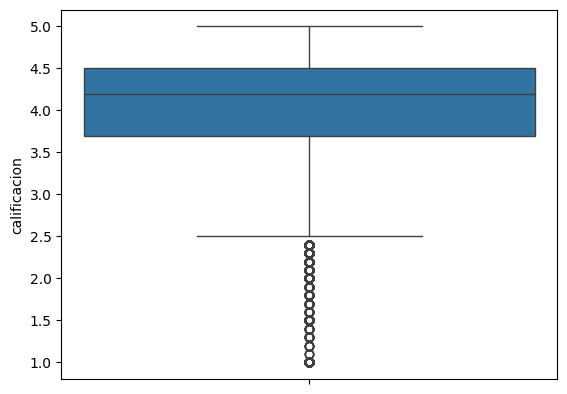

In [789]:
fig = sns.boxplot(df_restaurantes['calificacion'])
fig.plot()

In [790]:
df['calificacion'].describe()

count    111914.000000
mean          4.053937
std           0.665589
min           1.000000
25%           3.699219
50%           4.199219
75%           4.500000
max           5.000000
Name: calificacion, dtype: float64

Decidimos utilizar el promedio como umbral

In [791]:
umbral = df['calificacion'].mean()

In [792]:
df.loc[:, 'calificacion'] = df.loc[:, 'calificacion'].apply(lambda x: 1 if x >= umbral else 0)

In [793]:
df['calificacion'] = df['calificacion'].astype(int)

C:\Users\javier\AppData\Local\Temp\ipykernel_33520\1078177050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['calificacion'] = df['calificacion'].astype(int)


### 2.1.4 Selección de Features para el ML

In [794]:
dropear = ["nombre","index", "id_restaurante","categorias", "atributos","id_estado", "cantidad_resenas"]
# dropear = ["index", "id_restaurante","categorias", "atributos", "nombre"]

df = df.drop(columns=dropear)


### 2.1.5 Over y Under Sampling

In [795]:
df['calificacion'].value_counts()

calificacion
1    62971
0    48943
Name: count, dtype: int64

In [796]:
df = pd.concat([df.query("calificacion == 1").sample(48943),df.query("calificacion == 0")])

In [797]:
df['calificacion'].value_counts()

calificacion
1    48943
0    48943
Name: count, dtype: int64

In [798]:
# X_subway = df.query("nombre == 'Subway'").drop(['calificacion', 'nombre'], axis=1)
# y_subway = df.query("nombre == 'Subway'").loc[:, 'calificacion']
# X_nsubway = df.query("nombre != 'Subway'").drop(['calificacion', 'nombre'], axis=1)
# y_nsubway = df.query("nombre != 'Subway'").loc[:, 'calificacion']

# X_train, X_test, y_train, y_test = X_nsubway, X_subway, y_nsubway, y_subway

In [799]:
df[df.columns[:-4]] = df[df.columns[:-4]].astype(int)

## 2.2 Modelos

### 2.2.1 Regresión Logística

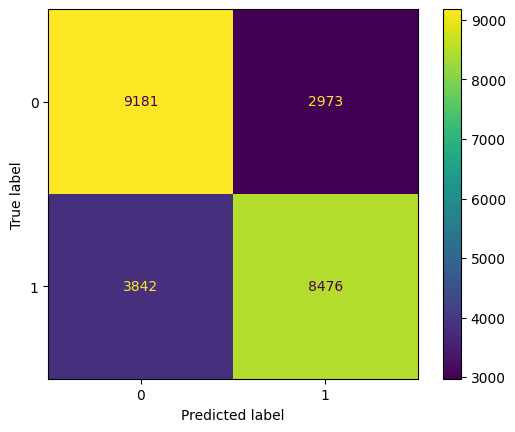

              precision    recall  f1-score   support

           0       0.70      0.76      0.73     12154
           1       0.74      0.69      0.71     12318

    accuracy                           0.72     24472
   macro avg       0.72      0.72      0.72     24472
weighted avg       0.72      0.72      0.72     24472

Validación: 0.7933122762325199
Train: 0.7940825372991703


In [827]:
scores = dict()

X = df.drop(['calificacion'], axis=1)
y = df['calificacion'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  # apply scaling on training data


pipe.score(X_test, y_test)  # 
scores["Random Forest Classifier"] = pipe.score(X_test, y_test)

cm = confusion_matrix(y_test, pipe.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()
print(classification_report(y_test, pipe.predict(X_test)))


results = cross_validate(pipe, X_train, y_train, cv = 15, return_train_score=True, scoring = 'roc_auc')

print('Validación:',results['test_score'].mean())
print('Train:',results['train_score'].mean())

g:\cursos_2023\HENRY\DATA07\PF\PF_DATAPT07\.venv10\lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
g:\cursos_2023\HENRY\DATA07\PF\PF_DATAPT07\.venv10\lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
g:\cursos_2023\HENRY\DATA07\PF\PF_DATAPT07\.venv10\lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
g:\cursos_2023\HENRY\DATA07\PF\PF_DATAPT07\.venv10\lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
g:\cursos_2023\HENRY\DATA07\PF\PF_DATAPT07\.venv10\lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warni

Mejores hiperparámetros: {'logisticregression__C': 1, 'logisticregression__class_weight': 'balanced', 'logisticregression__fit_intercept': True, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}


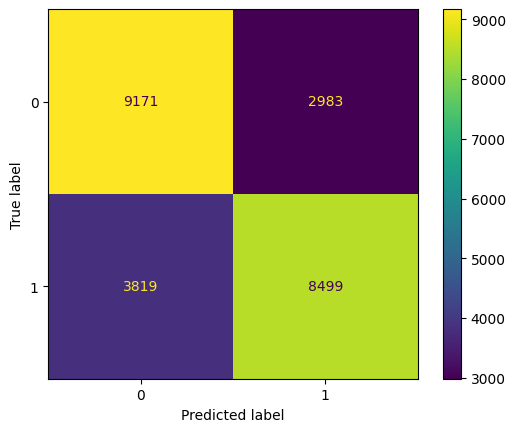

              precision    recall  f1-score   support

           0       0.71      0.75      0.73     12154
           1       0.74      0.69      0.71     12318

    accuracy                           0.72     24472
   macro avg       0.72      0.72      0.72     24472
weighted avg       0.72      0.72      0.72     24472

Validación: 0.793060860496823
Train: 0.7941511318286761


In [833]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Suponiendo que df es tu DataFrame y 'calificacion' es la columna objetivo dicotómica

# Dividir las características y la variable objetivo
X = df.drop(['calificacion'], axis=1)
y = df['calificacion'] 

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Crear una tubería (pipeline) con el escalador y el modelo de regresión logística
pipe = make_pipeline(StandardScaler(), LogisticRegression())

model = LogisticRegression()


param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l2', None],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    # 'logisticregression__max_iter': [100, 200, 300],
    # 'logisticregression__tol': [1e-4, 1e-3, 1e-2],
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__fit_intercept': [True, False]
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')

# Ajustar el GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_pipe = grid_search.best_estimator_

# Guardar las puntuaciones
scores = dict()
scores["Logistic Regression"] = best_pipe.score(X_test, y_test)

# Matriz de confusión
cm = confusion_matrix(y_test, best_pipe.predict(X_test))

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Imprimir el reporte de clasificación
print(classification_report(y_test, best_pipe.predict(X_test)))

# Validación cruzada
results = cross_validate(best_pipe, X_train, y_train, cv=5, return_train_score=True, scoring='roc_auc')

print('Validación:', results['test_score'].mean())
print('Train:', results['train_score'].mean())


0.7406423667865315


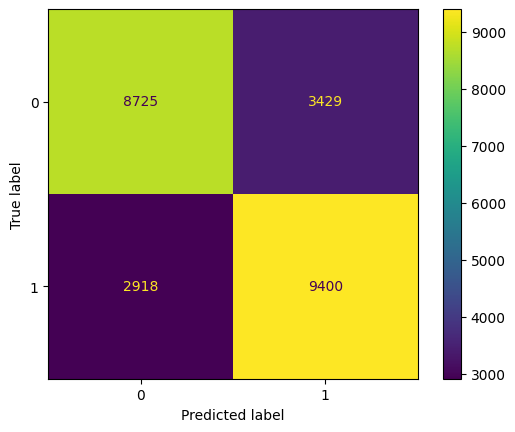

              precision    recall  f1-score   support

           0       0.75      0.72      0.73     12154
           1       0.73      0.76      0.75     12318

    accuracy                           0.74     24472
   macro avg       0.74      0.74      0.74     24472
weighted avg       0.74      0.74      0.74     24472



In [808]:
X = df.drop(['calificacion'], axis=1)
y = df['calificacion'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
# pipe = make_pipeline(StandardScaler(), LogisticRegression())
# pipe = make_pipeline(MaxAbsScaler(), LogisticRegression())
# pipe = make_pipeline(StandardScaler(), HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1))

pipe.fit(X_train, y_train)  # apply scaling on training data
scores["Random Forest Classifier"]= pipe.score(X_test, y_test)


print(pipe.score(X_test, y_test))  # 

cm = confusion_matrix(y_test, pipe.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()
print(classification_report(y_test, pipe.predict(X_test)))

0.7453416149068323


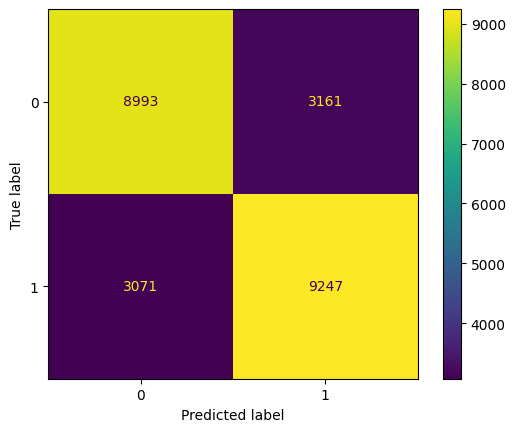

              precision    recall  f1-score   support

           0       0.75      0.74      0.74     12154
           1       0.75      0.75      0.75     12318

    accuracy                           0.75     24472
   macro avg       0.75      0.75      0.75     24472
weighted avg       0.75      0.75      0.75     24472



In [809]:
X = df.drop(['calificacion'], axis=1)
y = df['calificacion'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
# pipe = make_pipeline(StandardScaler(), LogisticRegression())
# pipe = make_pipeline(MaxAbsScaler(), LogisticRegression())
pipe = make_pipeline(StandardScaler(), HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1))

pipe.fit(X_train, y_train)  # apply scaling on training data
scores["HistGradientBoostingClassifier"] = pipe.score(X_test, y_test)

print(pipe.score(X_test, y_test))  # 

cm = confusion_matrix(y_test, pipe.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()
print(classification_report(y_test, pipe.predict(X_test)))

In [810]:

X = df.drop(['calificacion'], axis=1)
y = df['calificacion'] 

# Estandarizar las características
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo de regresión
reg_model = LinearRegression()
reg_model.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_pred_reg = reg_model.predict(X_test_scaled)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred_reg)



print(f'Mean Squared Error (Regresión): {mse}')

# Modelo de clasificación
clf_model = RandomForestClassifier(random_state=42)
clf_model.fit(X_train, y_train)
y_pred_clf = clf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_clf)
print(f'Accuracy (Clasificación): {accuracy}')
scores["Random Forest 2"] = accuracy_score(y_test, y_pred_clf)
random_forest_accuracy = accuracy


# Print classification report
print(classification_report(y_test, y_pred_clf))


Mean Squared Error (Regresión): 0.1884668536052598
Accuracy (Clasificación): 0.7396616541353384
              precision    recall  f1-score   support

           0       0.75      0.72      0.73     12154
           1       0.73      0.76      0.75     12318

    accuracy                           0.74     24472
   macro avg       0.74      0.74      0.74     24472
weighted avg       0.74      0.74      0.74     24472



In [811]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Supongamos que df es tu DataFrame y 'calificacion' es la columna objetivo dicotómica

# Dividir las características y la variable objetivo
X = df.drop(['calificacion'], axis=1)
y = df['calificacion']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo de regresión logística
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_pred = log_reg.predict(X_test_scaled)

# Calcular la precisión y otros métricos
accuracy = accuracy_score(y_test, y_pred)
scores["Logistic Regression 2"] = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.7212687710695679
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      9672
           1       0.74      0.69      0.71      9906

    accuracy                           0.72     19578
   macro avg       0.72      0.72      0.72     19578
weighted avg       0.72      0.72      0.72     19578

Confusion Matrix:
[[7323 2349]
 [3108 6798]]


Accuracy (XGBoost): 0.7461947083461028


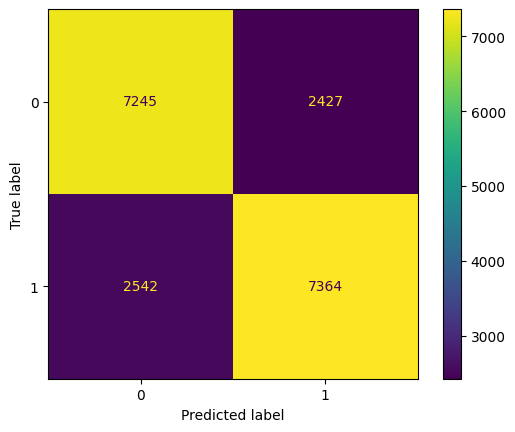

              precision    recall  f1-score   support

           0       0.74      0.75      0.74      9672
           1       0.75      0.74      0.75      9906

    accuracy                           0.75     19578
   macro avg       0.75      0.75      0.75     19578
weighted avg       0.75      0.75      0.75     19578



In [822]:

# Dividir los datos en conjuntos de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Definir los parámetros del modelo
params = {
    'objective': 'multi:softmax',  # Para clasificación multiclase
    'num_class': 2,  # Número de clases en la variable de salida
    'eval_metric': 'merror',  # Métrica de evaluación
    'learning_rate': 0.09,
    'max_depth': 5
}

# Entrenar el modelo XGBoost
num_rounds = 300

xgb_model = xgb.train(params, dtrain, num_rounds)

# Hacer predicciones
y_pred_xgb = xgb_model.predict(dtest)

# Evaluar el modelo
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy (XGBoost): {accuracy_xgb}')
scores["Random Forest (XGBoost)"] = accuracy_score(y_test, y_pred_xgb)

# xgboost_accuracy = accuracy_xgb

# from sklearn.metrics import classification_report

# # Print classification report
# print(classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()
print(classification_report(y_test, y_pred_xgb))


In [813]:
print(f"Columnas dropear {dropear}")
print(f"random forest: {round(random_forest_accuracy*100, 3)}")
print(f"linear reg   : {round(linear_reg_accuracy*100, 3)}" )
print(f"xgboost      : {round(xgboost_accuracy*100, 3)}"  )

print(scores)

Columnas dropear ['nombre', 'index', 'id_restaurante', 'categorias', 'atributos', 'id_estado', 'cantidad_resenas']
random forest: 73.966
linear reg   : 100.0
xgboost      : 74.599
{'Random Forest Classifier': 0.7406423667865315, 'HistGradientBoostingClassifier': 0.7453416149068323, 'Random Forest 2': 0.7459903973848196, 'Logistic Regression 2': 0.7212687710695679}


In [ ]:
# df_reviews = pd.read_parquet(r'Datawarehouse\reviewstexto.parquet')


- accesibilidad 10 columnas, 5 de yelp y 5 de google, (lift - elevator)
- beer - alcohol
- one hot encoding o level encoding a los estados
- crowd, family friend
- reseña, cloud, variables de peso
- balanceo de la variable target, min max scaler
- mapa mental de las categorías nuevas
- qué nuevos valores del ML agregar al Dashboard
- subir al datawarehouse las nuevas categorías
